# UNW to $\Delta$ SWE

In [53]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import xarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

## Pull in Interferogram for phase data

In [3]:
# Change to tmp directory and download staged tutorial data
os.chdir('/tmp')

!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/uavsar/ .  --recursive --exclude "*" --include "*tiff"

download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar

In [4]:
for unw_tiff_file in glob.glob("*unw.grd.tiff"):
    print(unw)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff


In [8]:
unw_rast = rio.open(unw_tiff_file)
meta_data1 = unw_rast.profile
print(meta_data1)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7014, 'height': 4768, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.30355248000001,
       0.0, -5.556e-05, 39.19030164), 'tiled': False, 'interleave': 'band'}


## Import Local Incidence Angle Raster

Processed (see scripts/incidence.ipynb) and stored locally for now (.inc files cannot currently be accessed from the ASF Vertex API, must be manually downloaded from the JPL site)

In [9]:
data_folder = '/home/jovyan/uavsar/grmesa_27416_21021_005_210322_L090_CX_01'
inc_tiff_file = os.path.join(data_folder, os.path.basename(data_folder) + '.inc.tiff')

In [11]:
inc_rast = rio.open(inc_tiff_file)
meta_data2 = inc_rast.profile
print(meta_data2)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8949, 'height': 4163, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.37516932000001,
       0.0, -5.556e-05, 39.17963412), 'tiled': False, 'interleave': 'band'}


## Display side by side

Using Jack's show_two_images code

In [50]:
# function for showing two images using matplotlib
plt.rcParams.update({'font.size': 12}) # set fontsize
def show_two_images(img1, img2, col1, col2, title1, title2, vmin1=None, vmax1=None, vmin2=None, vmax2=None):

    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # auto setting axis limits
    if vmin1 == None:
        vmin1 = np.nanpercentile(img1, 1)
    if vmax1 == None:
        vmax1 = np.nanpercentile(img1, 99)
    
    # plot image
    masked_array1 = np.ma.array(img1, mask=np.isnan(0)) #mask for 0
    plt1 = ax1.imshow(masked_array1, cmap=col1, vmin=vmin1, vmax=vmax1, interpolation = 'nearest') #fixes NaN problem
    ax1.set_title(title1)
    ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin1, vmax1))
        
    # add color scale
    colorbar = fig.colorbar(plt1, ax=ax1, fraction=0.03, pad=0.04)
    
     # auto setting axis limits
    if vmin2 == None:
        vmin2 = np.nanpercentile(img2, 1)
    if vmax2 == None:
        vmax2 = np.nanpercentile(img2, 99)
    
    # plot image
    masked_array2 = np.ma.array(img2, mask=np.isnan(0)) #mask for 0
    plt2 = ax2.imshow(masked_array2, cmap=col2, vmin=vmin2, vmax=vmax2, interpolation = 'nearest')
    ax2.set_title(title2)
    ax2.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin2, vmax2))
    colorbar = fig.colorbar(plt2, ax=ax2, fraction=0.03, pad=0.04)
    plt.show()
    #ax1.axis('equal')
    #ax2.axis('equal')


In [51]:
# masking no data values
unw_rast_raw = unw_rast.read(1)
unw_rast_raw[unw_rast_raw == 0] = np.nan

inc_rast_raw = inc_rast.read(1)
inc_rast_raw[inc_rast_raw == -10000] = np.nan

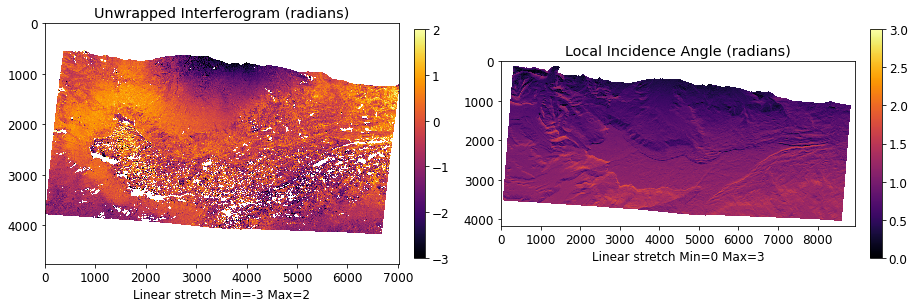

In [52]:
show_two_images(unw_rast_raw, inc_rast_raw, 'inferno', 'inferno', 'Unwrapped Interferogram (radians)', 'Local Incidence Angle (radians)', -3,2,0,3)

## Project to Same Grid

In [54]:
xds_unw = xarray.open_rasterio(unw_tiff_file)
xds_inc = xarray.open_rasterio(inc_tiff_file)

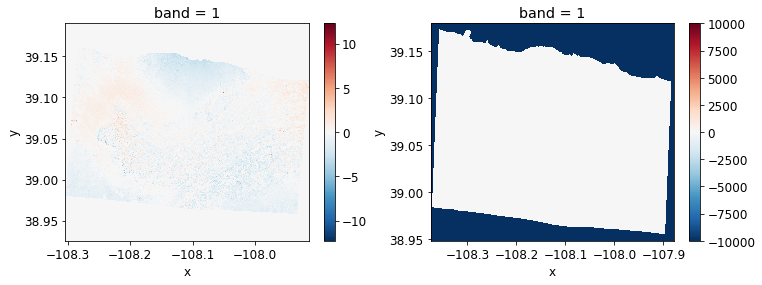

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
xds_unw.plot(ax=axes[0])
xds_inc.plot(ax=axes[1])
plt.draw()

## Phase to $\Delta$ SWE
$$
  \Delta SWE = \frac{\Delta \Phi \lambda_i}{2 \pi (1.59 + \theta_i^{5/2})}
$$ 